In [1]:
import torch
import tqdm
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.utils.meter import AverageValueMeter
from torch.utils.data import DataLoader, random_split
from utils.image_loading import load_training_images, load_groundtruth_images, load_test_images
from custom_datasets import Sat_Mask_Dataset_UPP_preprocessed
import albumentations as album
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
from torcheval.metrics.functional import multiclass_f1_score

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
# Preprocessing function
preprocess_input = get_preprocessing_fn('efficientnet-b5', pretrained='imagenet')
preprocess_input =  album.Compose([album.Lambda(image=preprocess_input), ToTensorV2()])

In [4]:
# Load original data
original_data = {}
original_data["images"] = load_training_images()
original_data["images"].extend(load_groundtruth_images("EPFL"))
original_data["masks"] = load_groundtruth_images()
original_data["masks"].extend(load_groundtruth_images("EPFL"))

In [5]:
# Load custom data for specified cities
city_names = ["boston", "nyc", "philadelphia", "austin"]
custom_data = {"images": [], "masks": []}
for name in city_names:
    custom_data["images"].extend(load_training_images(name))
    custom_data["masks"].extend(load_groundtruth_images(name))

In [6]:
# Create datasets
custom_data_set = Sat_Mask_Dataset_UPP_preprocessed(custom_data["images"], custom_data["masks"], min_street_ratio=0.03, max_street_ratio=1.0, upp_preprocess=preprocess_input)
original_data_set = Sat_Mask_Dataset_UPP_preprocessed(original_data["images"], original_data["masks"],  upp_preprocess=preprocess_input)
print("After cleanup, the dataset now contains", len(custom_data_set), "images")

Initialized dataset, checked for min,max street ratio. Discarded %: 0.10558751027115859  num discarded: 1028
Initialized dataset, checked for min,max street ratio. Discarded %: 0.0  num discarded: 0
After cleanup, the dataset now contains 8708 images


(400, 400, 3)


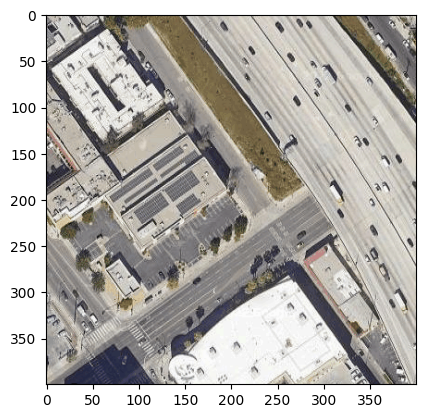

(400, 400, 3)


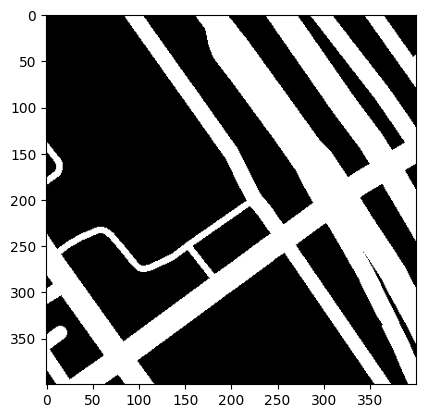

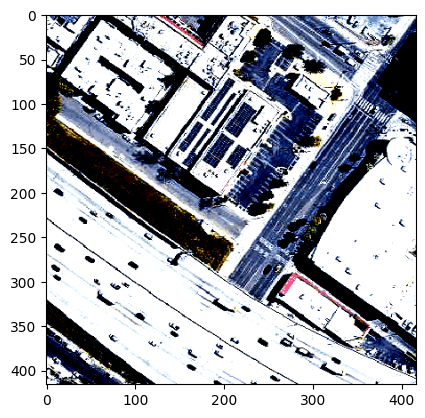

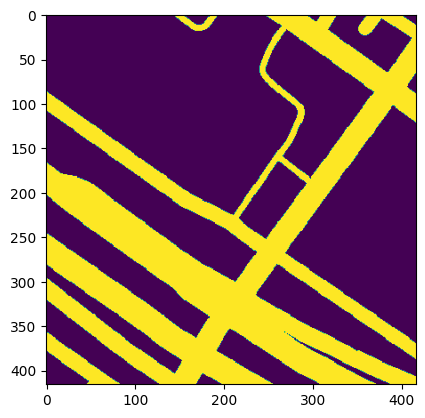

In [7]:
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

print(original_data["images"][0].shape)
plt.imshow(original_data["images"][0])
plt.show()
print(original_data["masks"][0].shape)
plt.imshow(original_data["masks"][0])
plt.show()
item = original_data_set.__getitem__(0)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask.squeeze(0))
plt.show()

In [8]:
# Split datasets into training and validation sets
train_size = int(0.8 * len(custom_data_set))
valid_size = len(custom_data_set) - train_size
train_dataset, valid_dataset = random_split(custom_data_set, [train_size, valid_size])

# Create data loaders
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

#### Configure UnetPlusPlus Model

In [9]:
# Define the model
model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b5",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
).to(device)

In [10]:
model_simple = smp.Unet(
    encoder_name="efficientnet-b5",
    encoder_depth=5,
    encoder_weights="imagenet",
    decoder_use_batchnorm=True,
    decoder_channels=(1024,512,256,64,16),
    decoder_attention_type=None,
    in_channels=3,
    classes=1,
    activation=None,
    aux_params=None
)

In [11]:
class_weights = torch.tensor([1./0.13]).to(device)
bce_loss = nn.BCEWithLogitsLoss(weight=class_weights)

def dice_loss(logits,masks, smooth=1e-6):
    probs = torch.sigmoid(logits)
    probs_flat = probs.reshape(-1)
    masks_flat = masks.reshape(-1)
    
    intersection = (probs_flat * masks_flat).sum()
    union = probs_flat.sum() + masks_flat.sum()
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff

def combined_loss_correct_dice(logits, masks, alpha=0.15, gamma=2.0, smooth=1e-6):
    # reshape the mask and predictions for the bce loss: 
    batch_size = logits.shape[0]
    logits_sq = logits.reshape((batch_size, 416*416))
    mask_sq = masks.reshape((batch_size, 416*416))
    
    return dice_loss(logits, masks, smooth=smooth) + bce_loss(logits_sq, mask_sq)

In [12]:
def mean_f1_score_from_logits(pred, mask):
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # compute the mean for all the images
    # computes the mean over the 0-th axis
    pred_classes = torch.round(torch.sigmoid(pred))
    return mean_f1_score_from_classes(mask,pred_classes)


def mean_f1_score_from_classes(preds,masks):
    
    # assume both inputs have the shape (batchsize,1, h,w), where h=w=1024
    # this computes the f1 over the whole batch, for each image in the batch alone:
    
    # first reshape the tensors
    b_size = masks.shape[0]
    f1_acc = 0.
    size = torch.prod(torch.tensor(masks.shape[1:]))
    for i in range(b_size):
        mask = masks[i]
        pred = preds[i]
        # reshape and compute f1
        f1_acc = f1_acc + multiclass_f1_score(pred.reshape((size)), mask.reshape((size)))
        
    mean_f1 = f1_acc/b_size
    return mean_f1

In [13]:
# Define optimizer, scheduler, and loss function
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, verbose=True, threshold=1e-6, factor=0.5)

/opt/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
print("Model loaded")
# how many trainable parameters does the model have?
print("Trainable parameters",sum(p.numel() for p in model.parameters() if p.requires_grad))
# how many total parameters does the model have?
print("Total parameters",sum(p.numel() for p in model.parameters()))

# percentage of trainable parameters
print("Percentage of trainable parameters: ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()))

Model loaded
Trainable parameters 54679105
Total parameters 54679105
Percentage of trainable parameters: 
1.0


#### Load The Data

torch.Size([3, 416, 416])
torch.Size([1, 416, 416])


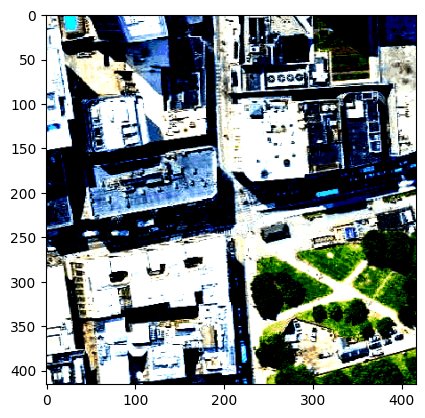

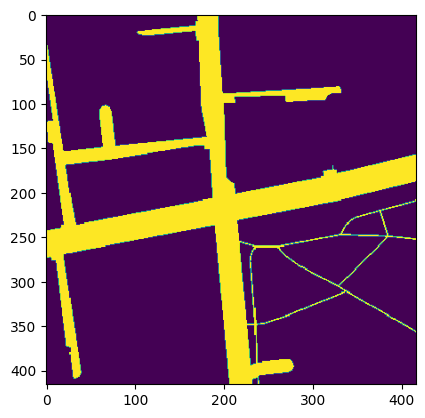

In [15]:
import matplotlib.pyplot as plt
import numpy as np 

item = train_loader.dataset[0]
print(item[0].shape)
print(item[1].shape)
img_normal = np.swapaxes(item[0], 0, 2)
img_mask = np.swapaxes(item[1], 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask)
plt.show()

In [18]:
# Training loop
for epoch in range(20):
    model.train()
    average_loss = 0
    f1_score = 0

    for data in tqdm.tqdm(train_loader, leave=False):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)

        loss = combined_loss_correct_dice(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)

    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(train_loader)}, F1: {f1_score / len(train_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

    torch.save(model.state_dict(), f"best_model_{epoch}.pth")
    # Validation loop
    model.eval()
    average_loss = 0
    f1_score = 0

    for x, y in tqdm.tqdm(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = combined_loss_correct_dice(y_pred, y)

        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)

    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Validation Loss: {average_loss / len(valid_loader)}, F1: {f1_score / len(valid_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

Epoch: 0, Training Loss: 1.458051828221235, F1: 0.9414241313934326


100%|██████████| 1742/1742 [01:51<00:00, 15.59it/s]


Epoch: 0, Training Loss: 1.3610411273180822, F1: 0.9455973505973816


Epoch: 1, Training Loss: 1.3426195824334406, F1: 0.9457463026046753


100%|██████████| 1742/1742 [01:51<00:00, 15.61it/s]


Epoch: 1, Training Loss: 1.2817098656337789, F1: 0.9485368728637695


Epoch: 2, Training Loss: 1.270974173521893, F1: 0.9484679102897644


100%|██████████| 1742/1742 [01:51<00:00, 15.60it/s]


Epoch: 2, Training Loss: 1.2622337528471284, F1: 0.9490208625793457


Epoch: 3, Training Loss: 1.2185517588424546, F1: 0.9503670930862427


100%|██████████| 1742/1742 [02:37<00:00, 11.05it/s]


Epoch: 3, Training Loss: 1.249030261461962, F1: 0.9504083395004272


Epoch: 4, Training Loss: 1.1721053500599636, F1: 0.9520448446273804


100%|██████████| 1742/1742 [02:37<00:00, 11.07it/s]


Epoch: 4, Training Loss: 1.2169109490602763, F1: 0.9510713815689087


Epoch: 5, Training Loss: 1.1299927022570004, F1: 0.9536300897598267


100%|██████████| 1742/1742 [02:37<00:00, 11.05it/s]


Epoch: 5, Training Loss: 1.2267576245811311, F1: 0.9504840970039368


Epoch: 6, Training Loss: 1.096937242783125, F1: 0.9548604488372803


100%|██████████| 1742/1742 [02:05<00:00, 13.85it/s]


Epoch: 6, Training Loss: 1.2198063009830211, F1: 0.9500216245651245


Epoch: 7, Training Loss: 1.061606648876472, F1: 0.9560865759849548


100%|██████████| 1742/1742 [02:08<00:00, 13.59it/s]


Epoch: 7, Training Loss: 1.2090713598954692, F1: 0.9518304467201233


Epoch: 8, Training Loss: 1.0277606521437808, F1: 0.9573185443878174


100%|██████████| 1742/1742 [02:09<00:00, 13.43it/s]


Epoch: 8, Training Loss: 1.2093676554657151, F1: 0.9522518515586853


Epoch: 9, Training Loss: 1.0013590246823802, F1: 0.9583976864814758


100%|██████████| 1742/1742 [02:05<00:00, 13.92it/s]


Epoch: 9, Training Loss: 1.2021345893513458, F1: 0.9526116847991943


Epoch: 10, Training Loss: 0.9763438221671147, F1: 0.9593052864074707


100%|██████████| 1742/1742 [01:55<00:00, 15.08it/s]


Epoch: 10, Training Loss: 1.1901910935114774, F1: 0.9531282186508179


Epoch: 11, Training Loss: 0.9472259875905394, F1: 0.960368812084198


100%|██████████| 1742/1742 [01:54<00:00, 15.25it/s]


Epoch: 11, Training Loss: 1.1805261256329365, F1: 0.9532514810562134


Epoch: 12, Training Loss: 0.9315631708164981, F1: 0.9610437154769897


100%|██████████| 1742/1742 [02:03<00:00, 14.05it/s]


Epoch: 12, Training Loss: 1.1879239244863442, F1: 0.9534716010093689


Epoch: 13, Training Loss: 0.9126800976405014, F1: 0.9617522954940796


100%|██████████| 1742/1742 [01:55<00:00, 15.12it/s]


Epoch: 13, Training Loss: 1.1963705018368025, F1: 0.9539113640785217


Epoch: 14, Training Loss: 0.8842212136198835, F1: 0.9628157615661621


100%|██████████| 1742/1742 [01:57<00:00, 14.84it/s]


Epoch: 14, Training Loss: 1.1905801934280982, F1: 0.9534803032875061


Epoch: 15, Training Loss: 0.8649544936940181, F1: 0.9634875655174255


100%|██████████| 1742/1742 [01:58<00:00, 14.70it/s]


Epoch: 15, Training Loss: 1.211059202069051, F1: 0.9533889293670654


Epoch: 16, Training Loss: 0.8478291282908647, F1: 0.96419358253479


100%|██████████| 1742/1742 [01:55<00:00, 15.10it/s]


Epoch: 16, Training Loss: 1.2055169953339135, F1: 0.9538421630859375


Epoch: 17, Training Loss: 0.8317286598160756, F1: 0.96481853723526


100%|██████████| 1742/1742 [01:55<00:00, 15.10it/s]


Epoch: 17, Training Loss: 1.2105600961177139, F1: 0.9537625312805176


Epoch: 18, Training Loss: 0.8135200614267305, F1: 0.9655554890632629


100%|██████████| 1742/1742 [01:55<00:00, 15.04it/s]


Epoch: 18, Training Loss: 1.2210878720924037, F1: 0.9538553953170776


Epoch: 19, Training Loss: 0.7940583547825792, F1: 0.9663052558898926


100%|██████████| 1742/1742 [01:57<00:00, 14.78it/s]

Epoch: 19, Training Loss: 1.2281531097643275, F1: 0.9545134902000427


torch.Size([3, 416, 416])
torch.Size([1, 416, 416])


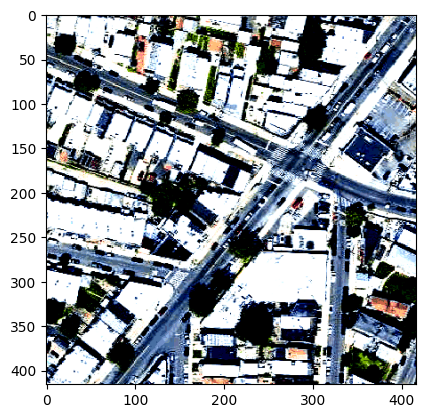

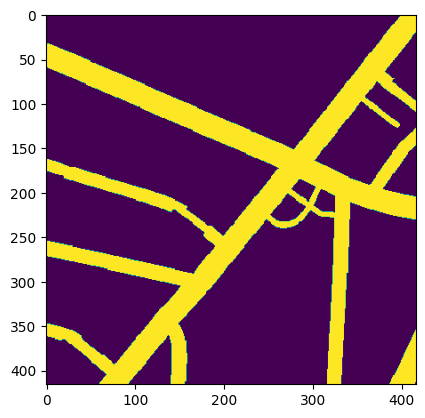

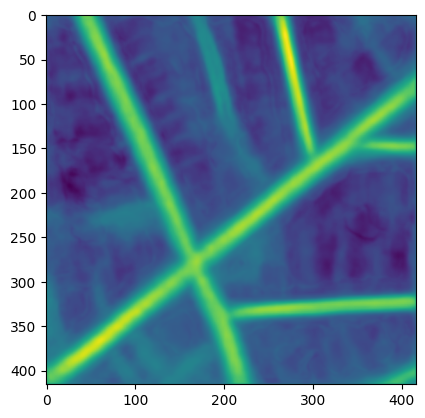

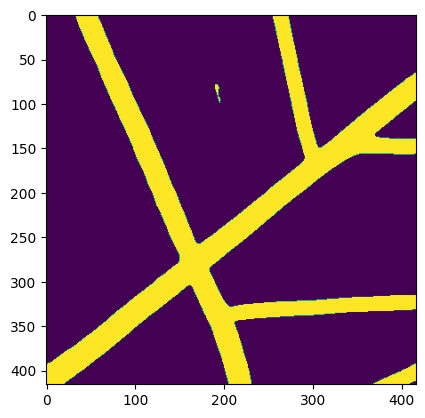

In [19]:
import matplotlib.pyplot as plt
import numpy as np 

item = valid_loader.dataset[0]
image_visual = item[0]
mask_visual = item[1]
print(image_visual.shape)
print(mask_visual.shape)
img_normal = np.swapaxes(image_visual, 0, 2)
img_mask = np.swapaxes(mask_visual, 0, 2)
plt.imshow(img_normal)
plt.show()
plt.imshow(img_mask)
plt.show()
model.eval()
pred = None
with torch.no_grad():
    image = image_visual.unsqueeze(0).to(device)
    pred = model(image).cpu()
plt.imshow(pred.squeeze())
plt.show()
plt.imshow(torch.round(torch.sigmoid(pred.squeeze())))
plt.show()

In [ ]:
# Load the saved model for further training on the original dataset
model.load_state_dict(torch.load("best_model_19.pth"))

<All keys matched successfully>

In [20]:
# Split the original dataset into training and validation sets
train_size = int(0.8 * len(original_data_set))
valid_size = len(original_data_set) - train_size
train_dataset, valid_dataset = random_split(original_data_set, [train_size, valid_size])

# Create new data loaders for the original dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [21]:
# Continue training loop with the original dataset
for epoch in range(10):
    model.train()
    average_loss = 0
    f1_score = 0

    for x, y in tqdm.tqdm(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model.forward(x)

        loss = combined_loss_correct_dice(y_pred, y)
        loss.backward()
        optimizer.step()

        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
        
    
    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Training Loss: {average_loss / len(train_loader)}, F1: {f1_score / len(train_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

    torch.save(model.state_dict(), f"best_model_postprocess_{epoch}.pth")
    # Validation loop
    model.eval()
    average_loss = 0
    f1_score = 0

    for x, y in valid_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model.forward(x)
            loss = combined_loss_correct_dice(y_pred, y)

        # Update loss and f1
        # Update loss and f1
        average_loss += loss.item()
        f1_score += mean_f1_score_from_logits(y_pred, y)
    
    # Print training logs for the current epoch
    print(f"Epoch: {epoch}, Validation Loss: {average_loss / len(valid_loader)}, F1: {f1_score / len(valid_loader)}")#, IOU: {metrics_meters["iou_score"]}, Accuracy: {metrics_meters["accuracy"]}")

100%|██████████| 39/39 [00:35<00:00,  1.09it/s]


Epoch: 0, Training Loss: 1.6411188993698511, F1: 0.9385348558425903
Epoch: 0, Training Loss: 1.135774024134996, F1: 0.9522395730018616


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


Epoch: 1, Training Loss: 1.045544629295667, F1: 0.9579945802688599
Epoch: 1, Training Loss: 1.0088603601467854, F1: 0.9577713012695312


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


Epoch: 2, Training Loss: 0.9060790034440848, F1: 0.9631782174110413
Epoch: 2, Training Loss: 0.966603230076785, F1: 0.9592940807342529


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


Epoch: 3, Training Loss: 0.8549099297095568, F1: 0.9645556211471558
Epoch: 3, Training Loss: 0.9482404286307948, F1: 0.9596861004829407


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


Epoch: 4, Training Loss: 0.818686482998041, F1: 0.9663311839103699
Epoch: 4, Training Loss: 0.9585572851403635, F1: 0.9586153030395508


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


Epoch: 5, Training Loss: 0.772843660452427, F1: 0.9676905870437622
Epoch: 5, Training Loss: 0.9329907014889984, F1: 0.9597801566123962


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


Epoch: 6, Training Loss: 0.7182694704104693, F1: 0.9699461460113525
Epoch: 6, Training Loss: 0.9324787400320781, F1: 0.9606448411941528


100%|██████████| 39/39 [00:34<00:00,  1.12it/s]


Epoch: 7, Training Loss: 0.6846006910006205, F1: 0.9713203310966492
Epoch: 7, Training Loss: 0.9606429159793318, F1: 0.9595040082931519


100%|██████████| 39/39 [00:35<00:00,  1.11it/s]


Epoch: 8, Training Loss: 0.6738916486501694, F1: 0.9716340899467468
Epoch: 8, Training Loss: 0.9163953816442161, F1: 0.9607510566711426


100%|██████████| 39/39 [00:37<00:00,  1.05it/s]


Epoch: 9, Training Loss: 0.6361295573222332, F1: 0.973222017288208
Epoch: 9, Training Loss: 0.9368426029817486, F1: 0.9607356190681458


In [ ]:
# Load the saved model for further training on the original dataset
model.load_state_dict(torch.load("best_model_postprocess_9.pth"))

<All keys matched successfully>

In [ ]:
from custom_datasets import Sat_Only_Image_UPP_preprocessed
kaggle_submission_images = load_test_images()
submission_data_set = Sat_Only_Image_UPP_preprocessed(kaggle_submission_images, upp_preprocess=preprocess_input)

In [ ]:
submission_dataloader = DataLoader(submission_data_set, batch_size=5, shuffle=False, drop_last=False, num_workers=4, persistent_workers=True)

In [ ]:
model.eval()
pair = valid_loader.dataset[0]
pred = None
with torch.no_grad():
    image = pair[0].unsqueeze(0).to(device)
    pred = model(image).cpu()

In [ ]:
print(pred.squeeze())
print(torch.max(pred))
print(torch.mean(pred))

tensor([[-1.4943, -1.7795, -1.7901,  ..., -1.8271, -2.1925, -1.5988],
        [-1.7157, -2.2854, -2.5492,  ..., -2.4632, -2.7322, -2.2529],
        [-2.1087, -2.6535, -3.0633,  ..., -2.8296, -3.0998, -2.5898],
        ...,
        [-1.9418, -2.2222, -2.0022,  ..., -3.1398, -3.3472, -2.4947],
        [-1.9147, -2.7661, -2.5781,  ..., -3.1802, -3.2946, -2.5572],
        [-1.2243, -2.0253, -2.2525,  ..., -2.5875, -2.3229, -1.6117]])
tensor(-1.2243)
tensor(-3.4513)


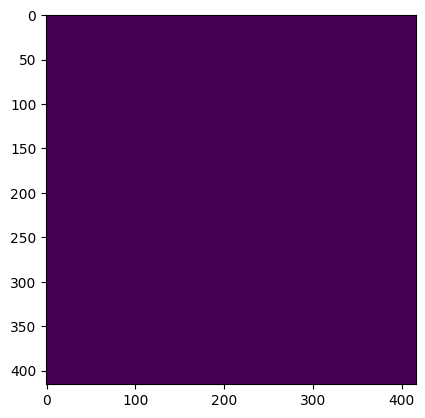

In [ ]:
plt.imshow(torch.round(pred.squeeze())))
plt.show()

In [ ]:
import torch.nn as nn

from tqdm import tqdm

model.eval()
predictions = []

with torch.no_grad():
    for image in tqdm(submission_dataloader):
        image = image.to(device)
        pred = model(image)
        predictions.append(pred.cpu())

100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


(400, 400, 3)
torch.Size([1, 224, 224])


TypeError: 'norm' must be an instance of matplotlib.colors.Normalize, str or None, not a int

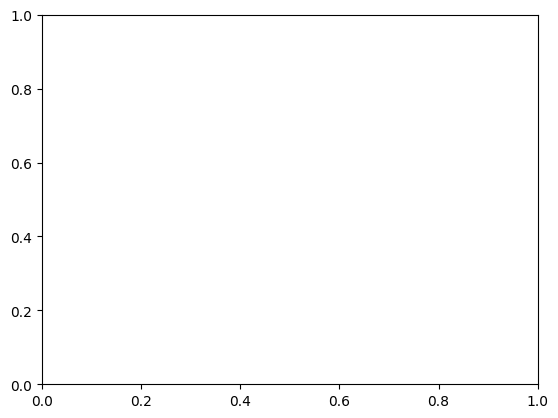

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 

# item = train_loader.dataset[0]
print(kaggle_submission_images[0].shape)
print(predictions[0][0].shape)
pair = (kaggle_submission_images[0], predictions[0][0])
# img_normal = np.swapaxes(pair[0], 0, 2)
# img_mask = np.swapaxes(pair[1], 0, 2)
# img_pred = np.swapaxes(pred.cpu().squeeze(0), 0, 2)
# plt.imshow(original_data["images"][0])
# plt.show()
# plt.imshow(original_data["masks"][0])
# plt.show()
# plt.imshow(img_normal)
# plt.show()
# plt.imshow(img_mask)
# plt.show()
plt.imshow(predictions[0][0].cpu(), 0, 2)
plt.show()

In [ ]:
print(img_pred)

tensor([[[[-2.5221, -3.8234, -3.8182,  ..., -4.2388, -3.6264, -2.9442],
          [-3.4085, -5.6575, -5.9417,  ..., -0.8478, -0.8853, -1.1346],
          [-2.7028, -4.3069, -4.5098,  ...,  3.5135,  2.9964,  1.7035],
          ...,
          [-0.5951, -0.9178, -0.5282,  ..., -1.4758, -1.2464, -1.2590],
          [ 0.5641,  0.8815,  1.2751,  ..., -4.9448, -4.4396, -3.5964],
          [-2.9129, -4.6514, -4.7792,  ..., -3.5654, -3.2904, -2.7217]]],


        [[[-3.6215, -4.7063, -4.5939,  ..., -5.1554, -4.8056, -4.0087],
          [-5.1085, -7.8551, -8.1471,  ..., -1.0731, -1.4103, -1.6518],
          [-3.9173, -5.3848, -5.5356,  ...,  4.8652,  4.2019,  2.5869],
          ...,
          [-0.5219, -0.7393, -0.8206,  ..., -1.8740, -1.8794, -1.7474],
          [ 0.4601,  0.7070,  1.0137,  ..., -6.1031, -5.8872, -4.7383],
          [-4.3144, -5.9549, -5.9591,  ..., -4.1005, -4.0527, -3.4182]]],


        [[[-3.9075, -4.9695, -4.6381,  ..., -5.1253, -4.8971, -4.1916],
          [-5.4481, -8.167